In [59]:
import os
import albumentations
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from tqdm import tqdm

In [70]:
import argparse
# if __name__ == '__main__':
    
parser = argparse.ArgumentParser(description="VQGAN")

parser.add_argument('--latent-dim', type=int, default=256, help='Latent dimension n_z (default: 256)')
parser.add_argument('--image-size', type=int, default=256, help='Image height and width (default: 256)')
parser.add_argument('--num-codebook-vectors', type=int, default=1024, help='Number of codebook vectors (default: 256)')
parser.add_argument('--beta', type=float, default=0.25, help='Commitment loss scalar (default: 0.25)')
parser.add_argument('--image-channels', type=int, default=3, help='Number of channels of images (default: 3)')
parser.add_argument('--dataset-path', type=str, default='/data', help='Path to data (default: /data)')
parser.add_argument('--device', type=str, default="cuda", help='Which device the training is on')
parser.add_argument('--batch-size', type=int, default=5, help='Input batch size for training (default: 6)')
parser.add_argument('--epochs', type=int, default=2, help='Number of epochs to train (default: 50)')
parser.add_argument('--learning-rate', type=float, default=2.25e-05, help='Learning rate (default: 0.0002)')
parser.add_argument('--beta1', type=float, default=0.5, help='Adam beta param (default: 0.0)')
parser.add_argument('--beta2', type=float, default=0.9, help='Adam beta param (default: 0.999)')
parser.add_argument('--disc-start', type=int, default=100, help='When to start the discriminator (default: 0)')
parser.add_argument('--disc-factor', type=float, default=1., help='')
parser.add_argument('--rec-loss-factor', type=float, default=1., help='Weighting factor for reconstruction loss.')
parser.add_argument('--perceptual-loss-factor', type=float, default=1., help='Weighting factor for perceptual loss.')

# parser.add_argument('--checkpoint-path', type=str, default=None, help='Path to the checkpoint to resume training from (default: None)')
# parser.add_argument('--checkpoint-vq-opt-path', type=str, default=None, help='Path to the VQ optimizer checkpoint to resume training from (default: None)')
# parser.add_argument('--checkpoint-disc-opt-path', type=str, default=None, help='Path to the discriminator optimizer checkpoint to resume training from (default: None)')

# args = parser.parse_args()

# args.dataset_path = r"C:\Users\luvve\flowersSix\jpg"


    # args.dataset_path = r"C:\Users\luvve\flowers\jpg"
    # args.checkpoint_path = r"C:\Users\luvve\VQGAN\checkpoints\vqgan_epoch_61.pt"
    # args.checkpoint_vq_opt_path = r"C:\Users\luvve\VQGAN\checkpoints\opt_vq_epoch_61.pt"
    # args.checkpoint_disc_opt_path = r"C:\Users\luvve\VQGAN\checkpoints\opt_disc_epoch_61.pt"

    # train_vqgan = TrainVQGAN(args)
    
import sys
print("sys.argv", sys.argv)
# sys.argv=['']
# del sys

args = parser.parse_args()
args.dataset_path = r"C:\Users\luvve\flowersSix\jpg"

print("args", args)

sys.argv ['']
args Namespace(latent_dim=256, image_size=256, num_codebook_vectors=1024, beta=0.25, image_channels=3, dataset_path='C:\\Users\\luvve\\flowersSix\\jpg', device='cuda', batch_size=5, epochs=2, learning_rate=2.25e-05, beta1=0.5, beta2=0.9, disc_start=100, disc_factor=1.0, rec_loss_factor=1.0, perceptual_loss_factor=1.0)


In [71]:
class ImagePaths(Dataset):
    def __init__(self, path, size=None):
        self.size = size

        self.images = [os.path.join(path, file) for file in os.listdir(path)]
        self._length = len(self.images)

        self.rescaler = albumentations.SmallestMaxSize(max_size=self.size)
        self.cropper = albumentations.CenterCrop(height=self.size, width=self.size)
        self.preprocessor = albumentations.Compose([self.rescaler, self.cropper])

    def __len__(self):
        return self._length

    def preprocess_image(self, image_path):
        image = Image.open(image_path)
        if not image.mode == "RGB":
            image = image.convert("RGB")
            
        # This converts the image data into a numpy array and 
        # ensures that the pixel values are in the range 0-255.
        
        image = np.array(image).astype(np.uint8)
        
        image = self.preprocessor(image=image)["image"]
        image = (image / 127.5 - 1.0).astype(np.float32)  # scaling image to be between -1 and 1
        image = image.transpose(2, 0, 1) # transformations due to mismatch between Pillow library and torch.
        return image

    def __getitem__(self, i):
        example = self.preprocess_image(self.images[i])
        return example

def load_data(args):
    train_data = ImagePaths(args.dataset_path, size=256)
    train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=False)
    return train_loader




image_paths.images ['C:\\Users\\luvve\\flowersSix\\jpg\\image_00659.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_00673.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_00804.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_00816.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_00829.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_00834.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_00843.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_00853.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_01211.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_01254.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_01456.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_01485.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_01775.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_01779.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_01781.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_01808.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_02193.jpg', 'C:\\Users\\luvve\\flowersSix\\jpg\\image_02194.jpg', 'C:\\Use

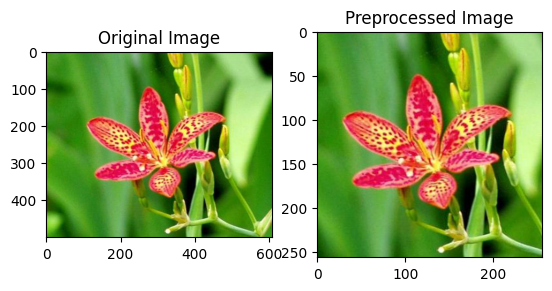

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Instantiate the ImagePaths class
image_paths = ImagePaths('C:\\Users\\luvve\\flowersSix\\jpg', size=256)

# Select an image randomly
image_path = np.random.choice(image_paths.images)
print("image_paths.images", image_paths.images)
# Load and preprocess the image
preprocessed_image = image_paths.preprocess_image(image_path)

# Load the original image for comparison
original_image = plt.imread(image_path)

# Since the preprocessed_image is in the range -1 to 1, rescale it to 0-1 for visualization
preprocessed_image = (preprocessed_image + 1) / 2

# Transpose the preprocessed image back to height x width x channels format
preprocessed_image = np.transpose(preprocessed_image, (1, 2, 0))

# Plot the original and preprocessed images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[1].imshow(preprocessed_image)
ax[1].set_title('Preprocessed Image')
plt.show()

In [73]:
train_dataset

In [74]:
from torch.utils.data import Dataset, DataLoader
train_dataset = load_data(args)
print("train_dataset", train_dataset)

 # depends on the batch size.. if iamges are 42, and batch_size = 1, steps per epioch will be 42. 
steps_per_epoch = len(train_dataset)  
print("steps_per_epoch", steps_per_epoch)

train_dataset <torch.utils.data.dataloader.DataLoader object at 0x000001FD13EFF7C0>
steps_per_epoch 9


In [75]:
resumed_epoch = 0
print(args.epochs)

2


In [77]:
class VQGAN_just_encoder(nn.Module):
    
    def __init__(self, args):
        
        super(VQGAN_just_encoder, self).__init__()
        self.encoder = Encoder(args).to(device=args.device)
        
    def forward(self, imgs):
        enccoder

In [76]:
for epoch in range(resumed_epoch+1,args.epochs):
    with tqdm(range(len(train_dataset))) as pbar:
        
        for i, imgs in zip(pbar, train_dataset):
            print("i", i)
            imgs = imgs.to(device = args.device)
            print("imgs.shape", imgs.shape)
            

 33%|████████████████████████████                                                        | 3/9 [00:00<00:00, 23.53it/s]

i 0
imgs.shape torch.Size([5, 3, 256, 256])
i 1
imgs.shape torch.Size([5, 3, 256, 256])
i 2
imgs.shape torch.Size([5, 3, 256, 256])
i 3
imgs.shape torch.Size([5, 3, 256, 256])


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 26.00it/s]

i 4
imgs.shape torch.Size([5, 3, 256, 256])
i 5
imgs.shape torch.Size([5, 3, 256, 256])
i 6
imgs.shape torch.Size([5, 3, 256, 256])
i 7
imgs.shape torch.Size([5, 3, 256, 256])
i 8
imgs.shape torch.Size([2, 3, 256, 256])
